In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path
root_path = Path.cwd().parent.parent.parent.absolute()
import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent.parent  # Go up 3 levels
pdpo_path = str(repo_root.absolute())
# Add repository root to path
sys.path.insert(0, pdpo_path)




In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrn
from jax import jit, vmap
from flax import nnx
import optax
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from typing import Dict, Tuple, Optional
import time

In [3]:
# Set plot style
plt.style.use('default')

# JAX Configuration
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())

device = jax.devices()[2]
jax.default_device(device)




JAX version: 0.7.0
Available devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [4]:
# Set random seed for reproducibility
SEED = 1
key = jrn.PRNGKey(SEED)
print(f"Random seed set to: {SEED}")

Random seed set to: 1


In [5]:
from pdpo.generative.models.matching_methods import FlowMatching,StochasticInterpolant
from pdpo.models.nn import create_mlp,get_activation_fn
from pdpo.data.toy_datasets import inf_train_gen
from pdpo.core.types import ModelParams, SampleArray, TimeArray
from pdpo.ode.solvers import MidpointSolver


In [6]:
# Test configuration
CONFIG = {
    'model': {
        'input_dim': 2,
        'hidden_dim': 128,
        'num_layers': 4,
        'activation': 'relu',
        'time_varying': True
    },
    'training': {
        'batch_size': 1000,
        'learning_rate': 1e-3,
        'num_epochs': 1000,
        'print_every': 100
    },
    'data': {
        'source': 'std_gaussian',
        'target': '8gaussians',
        'dim': 2
    }
}

In [7]:
print("Configuration loaded:")
for section, params in CONFIG.items():
    print(f"  {section}: {params}")

print("\n" + "="*50)
print("SETUP COMPLETE - Ready for Flow Matching tests")
print("="*50)

Configuration loaded:
  model: {'input_dim': 2, 'hidden_dim': 128, 'num_layers': 4, 'activation': 'relu', 'time_varying': True}
  training: {'batch_size': 1000, 'learning_rate': 0.001, 'num_epochs': 1000, 'print_every': 100}
  data: {'source': 'std_gaussian', 'target': '8gaussians', 'dim': 2}

SETUP COMPLETE - Ready for Flow Matching tests


In [8]:
get_activation_fn('relu')

In [9]:
architecture = [
    CONFIG['model']['input_dim'],      # 2 - input dimension  
    CONFIG['model']['num_layers'],     # 4 - number of layers
    CONFIG['model']['hidden_dim'],     # 64 - hidden layer width
    CONFIG['model']['activation'],      # 'relu' - activation function
    CONFIG['model']['time_varying']
]

print(f"MLP Architecture: {architecture}")
print(f"  - Input dimension: {architecture[0]}")
print(f"  - Hidden width: {architecture[1]}")  
print(f"  - Number of layers: {architecture[2]}")
print(f"  - Activation: {architecture[3]}")

MLP Architecture: [2, 4, 128, 'relu', True]
  - Input dimension: 2
  - Hidden width: 4
  - Number of layers: 128
  - Activation: relu


In [10]:
vf_model = create_mlp(input_size = architecture[0],
num_layers = architecture[1],
layer_width = architecture[2],
activation = architecture[3],
time_varying = architecture[4]
)


nnx.display(vf_model)

/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/renderers.py:251: UserWarning: Ignoring error inside wrapper hook <function use_autovisualizer_if_present at 0x75db0cd32b60>:
Traceback (most recent call last):
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/renderers.py", line 225, in _render_subtree
    postprocessed_result = hook(
        node=node, path=path, node_renderer=render_without_this_hook
    )
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/_internal/handlers/autovisualizer_hook.py", line 47, in use_autovisualizer_if_present
    result = autoviz(node, path)
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/_internal/api/array_autovisualizer.py", line 306, in __call__
    jax.sharding.PositionalSharding
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/jax/_src/deprecations.py", line 54, in getattr
    raise Attrib

In [11]:
optimizer = nnx.Optimizer(vf_model,optax.adam(CONFIG['training']['learning_rate']),wrt = nnx.Param)


In [12]:
ode_solver = MidpointSolver

In [20]:
# model = FlowMatching(
#     vf_model = vf_model,
#     optimizer = optimizer,
#     ode_solver = ode_solver
# )

model = StochasticInterpolant(
    vf_model = vf_model,
    optimizer = optimizer,
    ode_solver = ode_solver
)

In [21]:
# Training setup
batch_size = CONFIG['training']['batch_size']
num_epochs = CONFIG['training']['num_epochs']
losses = []

print(f"Training config: {num_epochs} epochs, batch_size={batch_size}, lr={CONFIG['training']['learning_rate']}")

Training config: 1000 epochs, batch_size=1000, lr=0.001


Epoch   0: Loss = 8.150937


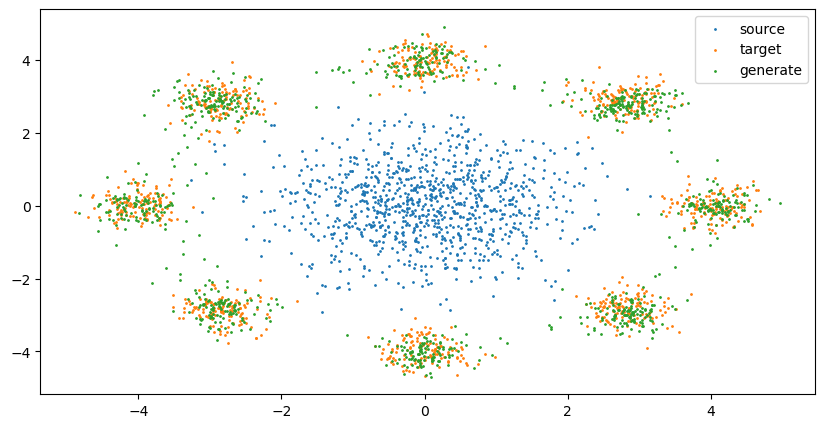

Epoch 100: Loss = 7.337945


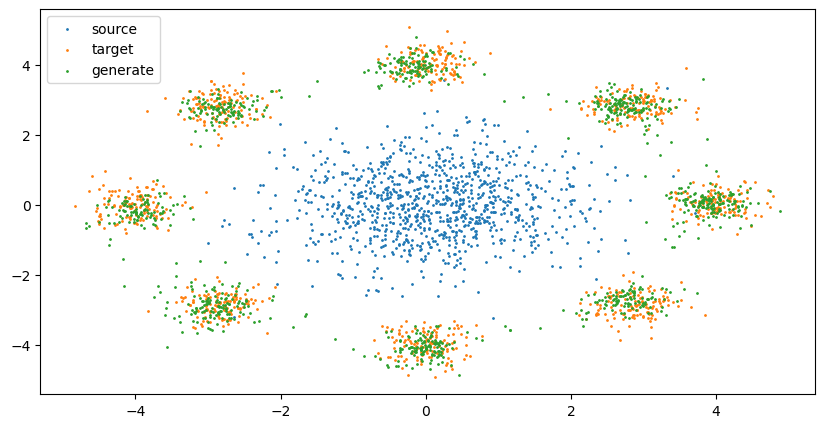

Epoch 200: Loss = 7.728614


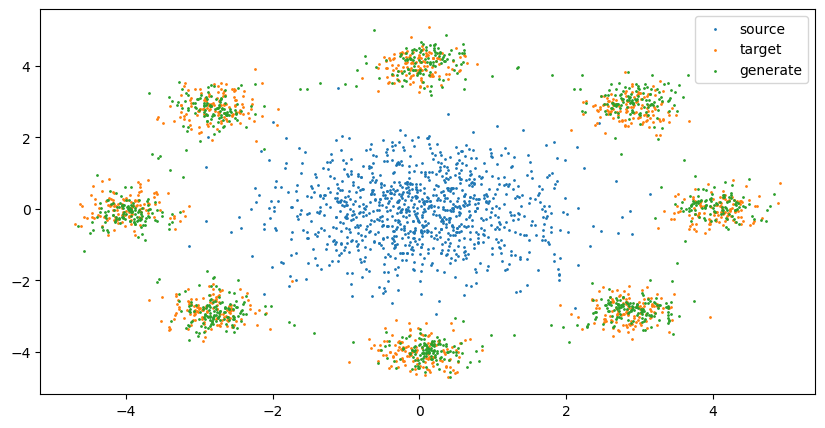

Epoch 300: Loss = 7.976543


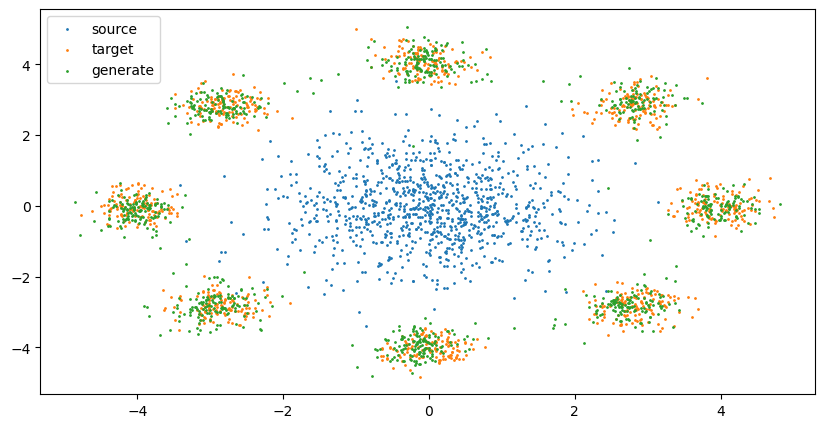

Epoch 400: Loss = 7.565075


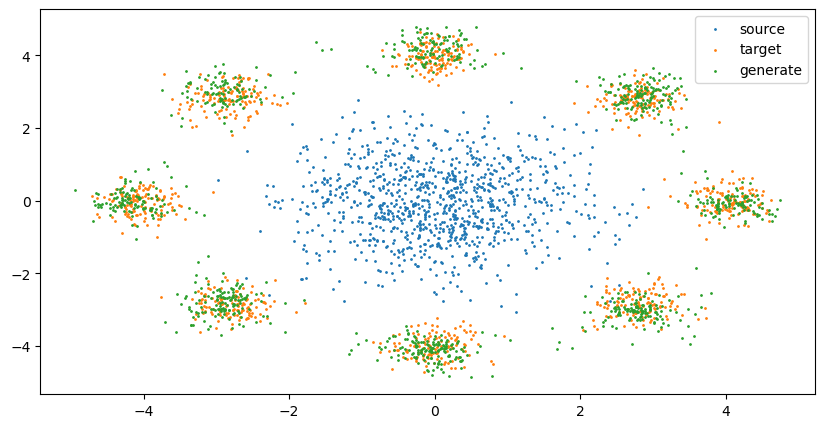

Epoch 500: Loss = 7.593329


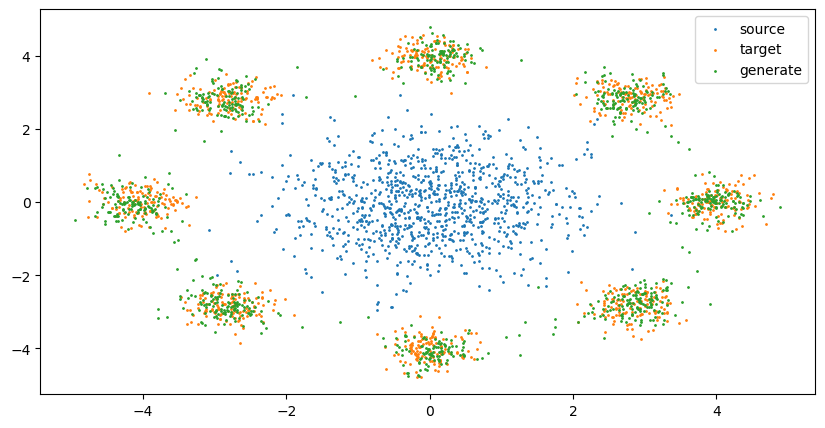

Epoch 600: Loss = 7.926716


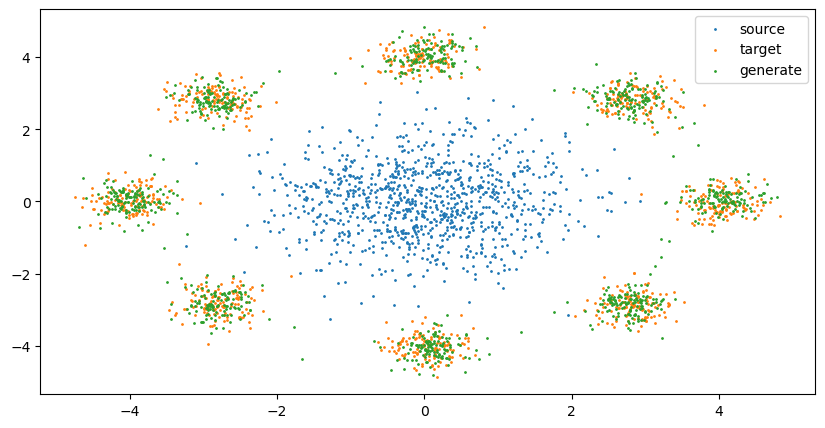

Epoch 700: Loss = 8.292151


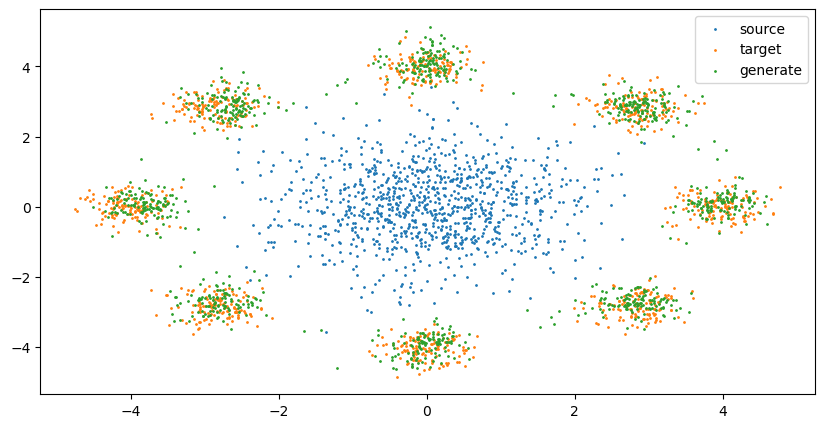

Epoch 800: Loss = 8.113400


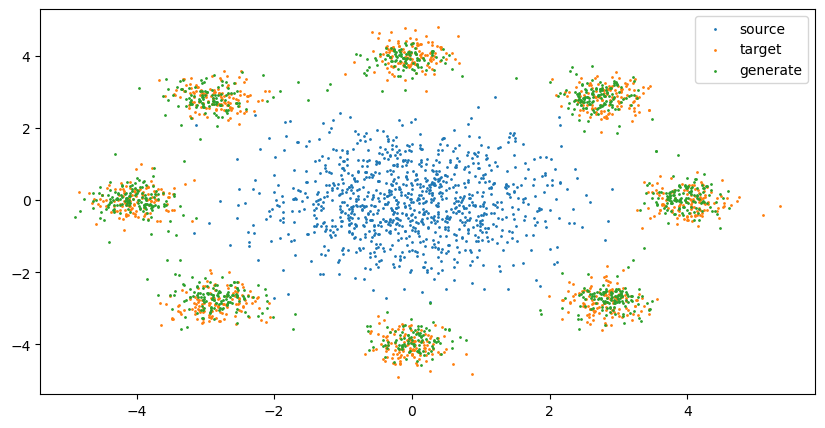

Epoch 900: Loss = 7.812810


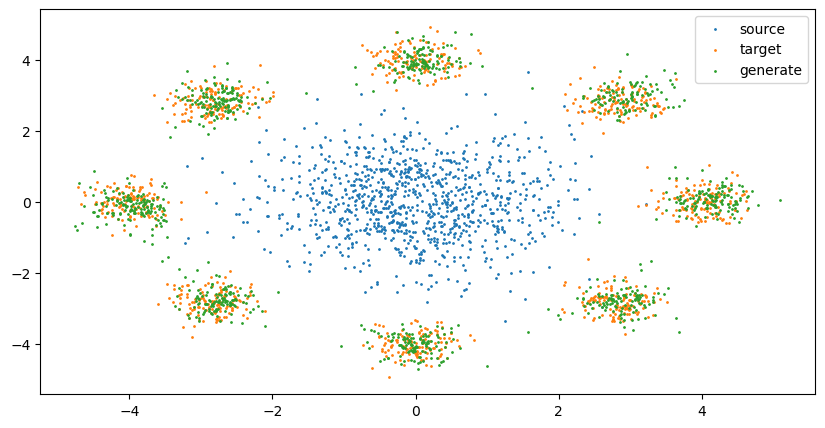

In [22]:
key_train = key
for epoch in range(num_epochs):
    # Generate training data
    key_train, key_batch = jrn.split(key_train)
    source_data = inf_train_gen(CONFIG['data']['source'], key_batch, batch_size, CONFIG['data']['dim'])
    target_data = inf_train_gen(CONFIG['data']['target'], key_batch, batch_size, CONFIG['data']['dim'])
    
    # Training step
    loss, metrics = model.training_step(key_batch, target_data,source_data)
    
    
    losses.append(float(loss))
    
    if epoch % CONFIG['training']['print_every'] == 0:
        print(f"Epoch {epoch:3d}: Loss = {loss:.6f}")
        generated = model.sample_trajectory(
            x0 = source_data,
            ode_solver = ode_solver
        )
        fig = plt.figure(figsize=(10,5))
        plt.scatter(source_data[:,0],source_data[:,1],s= 1, label = 'source')
        plt.scatter(target_data[:,0],target_data[:,1],s = 1, label = 'target')
        plt.scatter(generated[:,0],generated[:,1],s = 1, label = 'generate')
        plt.legend()
        plt.show()
        

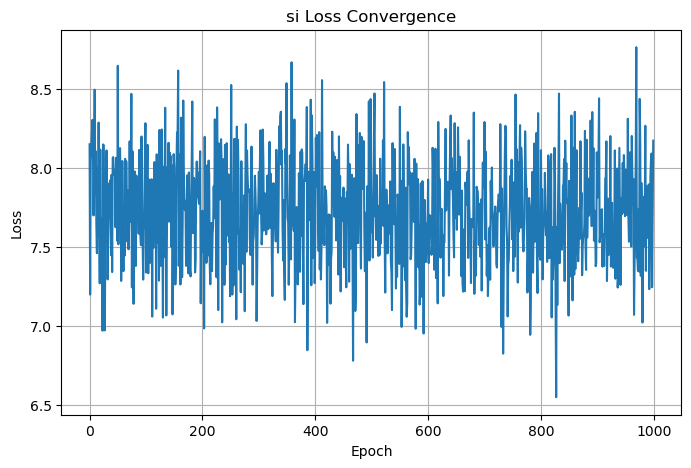

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{model.method_name} Loss Convergence')
plt.grid(True)
plt.show()

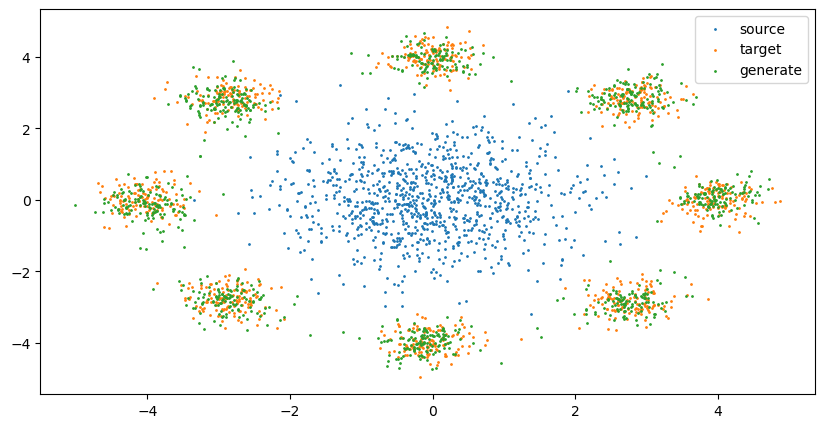

In [24]:
generated = fm_model.sample_trajectory(
x0 = source_data,
ode_solver = ode_solver
)
fig = plt.figure(figsize=(10,5))
plt.scatter(source_data[:,0],source_data[:,1],s= 1, label = 'source')
plt.scatter(target_data[:,0],target_data[:,1],s = 1, label = 'target')
plt.scatter(generated[:,0],generated[:,1],s = 1, label = 'generate')
plt.legend()
plt.show()